In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_classification
np.random.seed(42)

### 공통 예측 함수
* Logistic Regression
  * binary classification
  * $x \rightarrow p(y=1\mid x)$
  * 출력은 0과 1 사이의 확률
* 모델 구조
  * predict함수로 구현
  * 선형 조합: $z=w^{\top}X + b$
  * 확률 변환: $\hat{y}=\sigma(z)=\frac{1}{1+e^{-z}}$
* 손실함수
  * Binary Cross-Entropy
  * $L = -\frac{1}{m} \sum^m_{i=1}[y_i log(\hat{y}_i) + (1-y_i) log(1-\hat{y}_i) ]$
* 학습
  * 손실 함수를 w, b에 대해 미분해서 gradient 계산
  * optimizer update에 사용
  * weight: $dw = \frac{1}{m} \sum_i(\hat{y}_i - y_i)x_i$
  * bias: $db = \frac{1}{m} \sum_i(\hat{y}_i - y_i)$

In [35]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
    

def predict(X, w, b):
    z = np.dot(X, w) + b
    return sigmoid(z)
    

def binary_cross_entropy(y_true, y_pred, eps=1e-8):
    left_hand = y_true * np.log(y_pred + eps)
    right_hand = (1- y_true) * np.log(1- y_pred + eps)
    return - np.mean(left_hand + right_hand)
    

def gradient(X, y_true, y_pred):
    m = len(y_true)
    dw = np.dot(X.T, (y_pred - y_true)) / m
    db = np.mean(y_pred - y_true)
    return dw, db
    

def visualize(losses, optimizer):
    plt.plot(losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(optimizer.name.upper())
    plt.ylim(0, max(losses))
    plt.show()
    plt.close()

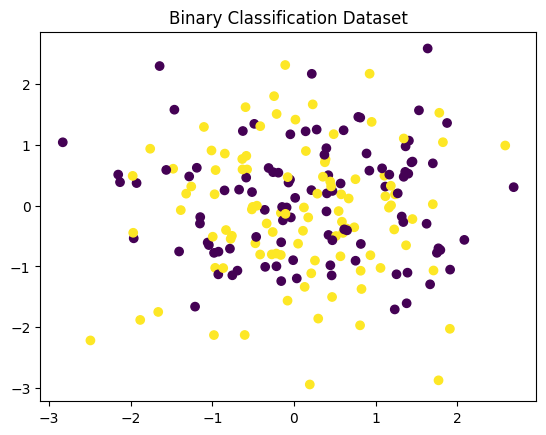

In [30]:
# common settings
n_epochs = 50
lr = 0.1
n_features = 20

# logistic regression
_w = np.random.randn(n_features, 1)
_b = np.zeros([1])

# binary classification dataset
X, y = make_classification(
    n_samples=200,
    n_features=n_features,
    n_redundant=0,
    n_informative=2,
    random_state=42
)


plt.scatter(X[:, 0], X[:, 1], c=y)
plt.title("Binary Classification Dataset")
plt.show()

## 1. Stochastic Gradient Descent(SGD)

* 정의
  * 확률적 경사 하강법
    * 전체 데이터에서 일부를 확률적으로 사용해서 기울기 계산
  * 전체 데이터에서 일부의 훈련 샘플을 사용하여 gradient를 계산하고 매개 변수를 업데이트
    * 모든 데이터를 한번에 계산하기에는 메모리, 계산 시간 등의 문제가 있음
    * 일부씩 모든 데이터를 한 바퀴 쭉 사용함
  * 계산 비용을 절감, 비선형 최적화 문제에 대한 솔루션으로  **근사**
* 수식
  * $w := w - \eta \nabla_w L(w)$
  * w: 학습중인 파라미터
  * $\eta$: learning rate (학습률)
  * $L(w)$: 손실 함수
  * $\nabla_wL(w)$:w에 대한 손실의 기울기(gradient)
* 특징
  * 단순하고 빠름: 계산량이 적어서 대규모 데이터에서도 효율적
  * 노이즈: 일부의 데이터로 gradient를 구하기 떄문에 업데이트 변동이 큼
  * 학습률이 중요: 너무 크면 발산, 너무 작으면 느림

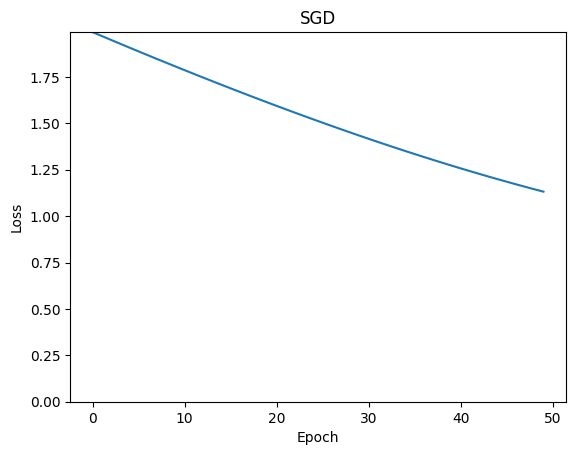

In [31]:
from src.optimizers import SGD
w = _w.copy()
b = _b.copy()

optimizer = SGD(lr)
losses = []

for epoch in range(n_epochs):
    y_pred = predict(X, w, b)
    loss = binary_cross_entropy(y, y_pred)
    dw, db = gradient(X, y, y_pred)

    # update: SGD
    w = optimizer.update(w, dw)
    b -= lr * db

    losses.append(loss)

visualize(losses, optimizer)